In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data, path_labels):

    image_list = []
    

    for filename in tqdm.tqdm(sorted(glob.glob(path_data), key=natural_keys)): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        #imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = path_labels    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [7]:
p_data = '/home/jovyan/DATA_MASTER_PROJECT/Leav_one_out_data_set/ADR_CONTROL_OUT/LEBETALOL_OUT/'

train_data =  p_data + 'TRAIN/*.tiff'
train_lab= p_data + 'train_lab.csv'

validation_data = p_data + 'VALIDATION/*.tiff'
validation_lab = p_data + 'validation_lab.csv'


test_data= p_data + 'TEST/*.tiff'
test_lab= p_data + 'test_lab.csv'



In [8]:
x_train, y_train = loadImages(train_data, train_lab)
x_train.shape, y_train.shape

100%|██████████| 49080/49080 [00:48<00:00, 1014.61it/s]


((49080, 90, 90, 3), (49080,))

In [9]:
x_val, y_val = loadImages(validation_data, validation_lab)
x_val.shape, y_val.shape

100%|██████████| 12758/12758 [00:10<00:00, 1168.51it/s]


((12758, 90, 90, 3), (12758,))

In [10]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

100%|██████████| 10423/10423 [00:08<00:00, 1165.55it/s]


((10423, 90, 90, 3), (10423,))

In [11]:
x_train = resize(x_train)
x_train.shape

(49080, 64, 64, 3)

In [12]:
x_val = resize(x_val)
x_val.shape

(12758, 64, 64, 3)

In [13]:
x_test = resize(x_test)
x_test.shape

(10423, 64, 64, 3)

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [15]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [16]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 12869, 1: 36211}

In [17]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print('weights = ' + str(weights))

weights = [1.90690807 0.67769462]


In [18]:
x_train = preprocess_input(x_train)

x_val = preprocess_input(x_val)

x_test = preprocess_input(x_test)


In [19]:
batch_size = 128

In [20]:
datagen = ImageDataGenerator()

datagen.fit(x_train)

train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(BatchNormalization())
m4.add(Activation('relu'))
m4.add(Dense(64, activation='relu'))
#m4.add(Dropout(0.5))

m4.add(Dense(1,activation='sigmoid'))

m4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 256)         1735488   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [21]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-3)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = (val_gen), 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                 verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 383.4375 steps, validate for 99.671875 steps
Epoch 1/100
384/383 [==============================] - 15s 38ms/step - loss: 0.4678 - accuracy: 0.7687 - val_loss: 0.4671 - val_accuracy: 0.7669
Epoch 2/100
384/383 [==============================] - 11s 29ms/step - loss: 0.3835 - accuracy: 0.8194 - val_loss: 0.4610 - val_accuracy: 0.7726
Epoch 3/100
384/383 [==============================] - 11s 29ms/step - loss: 0.3345 - accuracy: 0.8493 - val_loss: 0.4600 - val_accuracy: 0.7736
Epoch 4/100
384/383 [==============================] - 11s 29ms/step - loss: 0.3005 - accuracy: 0.8688 - val_loss: 0.4723 - val_accuracy: 0.7777
Epoch 5/100
384/383 [==============================] - 11s 29ms/step - loss: 0.2716 - accuracy: 0.8835 - val_loss: 0.4787 - val_accuracy: 0.7699
Epoch 6/100
384/383 [==============================] - 11s 29ms/step - loss: 0.2491 - accuracy: 0.8962 - val_loss: 0.4825 - val_accuracy: 0.7687
Epoch 00006: early stoppi

In [22]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 383.4375 steps, validate for 99.671875 steps
Epoch 1/100
384/383 [==============================] - 27s 70ms/step - loss: 0.2131 - accuracy: 0.9163 - val_loss: 0.5303 - val_accuracy: 0.7858
Epoch 2/100
384/383 [==============================] - 26s 66ms/step - loss: 0.1839 - accuracy: 0.9324 - val_loss: 0.5743 - val_accuracy: 0.7704
Epoch 3/100
384/383 [==============================] - 26s 67ms/step - loss: 0.1652 - accuracy: 0.9411 - val_loss: 0.5076 - val_accuracy: 0.7686
Epoch 4/100
384/383 [==============================] - 25s 66ms/step - loss: 0.1503 - accuracy: 0.9494 - val_loss: 0.5215 - val_accuracy: 0.7846
Epoch 5/100
384/383 [==============================] - 26s 67ms/step - loss: 0.1373 - accuracy: 0.9554 - val_loss: 0.4684 - val_accuracy: 0.7877
Epoch 6/100
384/383 [==============================] - 26s 67ms/step - loss: 0.1264 - accuracy: 0.9610 - val_loss: 0.4987 - val_accuracy: 0.7834
Epoch 7/100
384/383 [====

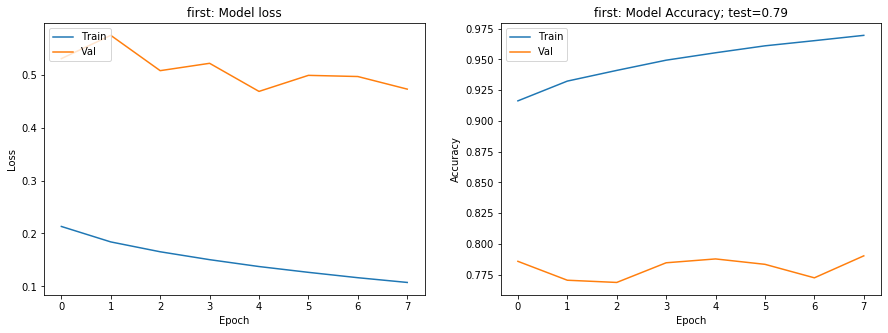

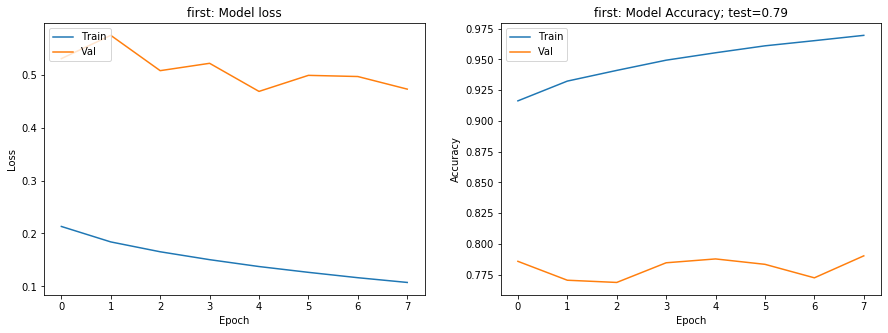

In [23]:
plot_history(m4_h, 'first')

In [24]:
scores = m4.evaluate(x_test, y_test, verbose = 1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))


10423/10423 [==============================] - 3s 242us/sample - loss: 3.2183 - accuracy: 0.2152

accuracy: 21.52%


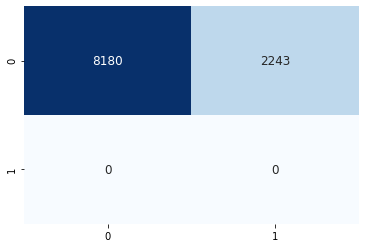

array([[8180, 2243],
       [   0,    0]])

In [25]:
test_preds = m4.predict(x_test)

t= []
for i in (test_preds):
    if i > 0.5:
        t.append(0)
    else:
        t.append(1)

draw_confusion_matrix(y_test, t)

In [ ]:
print(classification_report(y_test, t))

In [ ]:
from sklearn.metrics import precision_recall_curve


In [ ]:
pr, re ,th = precision_recall_curve(y_test,test_preds)

In [ ]:
def plot_pre_rec_curve(pr, re ,th):
    plt.plot(th,pr [:-1],'b--', label = 'Precision')
    plt.plot(th,re [:-1], 'g-', label = 'Rec')
    plt.xlabel('Thresh')
    plt.legend(loc = 'center left')
    plt.ylim([0,1])

In [ ]:
plot_pre_rec_curve(pr, re ,th )
plt.show

In [ ]:
#p = '/home/jovyan/Saved_Models/'
#m4.save(p + "CNN_same_fields_view_ADR_HRH.h5")